# import packages

In [2]:
import pysam
import os
import matplotlib.pyplot as plt
import scanpy as sc
from anndata import AnnData
#from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import os
from scipy.sparse import csr_matrix
from tqdm import tqdm
#import pickle5 as pkl
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)
#from datetime import datetime
import time
#import pickle5 as pkl
import edlib
#import editdistance
from functools import reduce
import json
from Bio.Seq import Seq
ad_seq=[('N', 'A'), ('N', 'T'), ('N', 'G'), ('N', 'C')]
slseq='TCTTCAGCGTTCCCGAGA'
import subprocess
from pathlib import Path

def rev(seq):
    return(str(Seq(seq).reverse_complement()))

def sort_cnt(arr):
    npcnt=np.array(np.unique(arr,return_counts=True)).T
    dfcnt=pd.DataFrame(npcnt)
    dfcnt[1]=dfcnt[1].astype('int')
    dfcnt=dfcnt.sort_values(by=1,ascending=False)
    return dfcnt

def rounder(adata):
    rad=1500/.73;pad=50;
    rx=np.mean(adata.obs['x']);ry=np.mean(adata.obs['y'])
    #adata.obs['x']=adata.obs['x']-rx;adata.obs['y']=adata.obs['y']-ry
    #adata.obsm['spatial']=adata.obs[['x','y']].values
    adata=adata[(adata.obs['x']-rx)**2+(adata.obs['y']-ry)**2<=rad**2].copy()

    crop=[np.min(adata.obsm['spatial'][:,0])-pad,np.max(adata.obsm['spatial'][:,0])+pad,\
    np.max(adata.obsm['spatial'][:,1])+pad,np.min(adata.obsm['spatial'][:,1])-pad]
    return adata,crop

def marker_plot(adata,puck,markers,crop,t=0,nrow=10,ncol=5,wd=6,spot=50,alpha=.6,rembar=True,vmx='p99.2',alpha_img=.3):
    fig, ax = plt.subplots(nrow, ncol, figsize=(ncol*wd,nrow*wd), gridspec_kw={'wspace':0.01})
    axr=ax.ravel()
    #sc.pl.spatial(adata, color='total_counts',vmax='p99.2',spot_size=40,frameon=False,
    #                  crop_coord=crop,cmap='plasma',alpha=.6,ax=axr[0], show=False)
    for i,gene in enumerate(markers):
        #i=i+1
        try:
            #ad=adata[ (adata[:,gene].X>0)]
            #if ad.shape[0]>10000:
            #    t=0;print(ad.shape[0],gene,adata[ (adata[:,gene].X>t)].shape[0])
            #else:
            #    t=0;print(ad.shape[0],gene)
            if vmx is not None:
                
                sc.pl.spatial(adata[ (adata[:,gene].X>t)], color=gene,vmax=vmx,
                          spot_size=spot,ax=axr[i], show=False,frameon=False,#frameon=True,
                              crop_coord=crop,
                              #crop_coord=[300,5000,5100,400],
                              #crop_coord=[500,4600,4800,400],
                              cmap='plasma',alpha=alpha,alpha_img=alpha_img)
            else:
                sc.pl.spatial(adata[ (adata[:,gene].X>t)], color=gene,
                          spot_size=spot,ax=axr[i], show=False,frameon=False,#frameon=True,
                              crop_coord=crop,
                              #crop_coord=[300,5000,5100,400],
                              #crop_coord=[500,4600,4800,400],
                              cmap='plasma',alpha=alpha,alpha_img=alpha_img)
            #scalebar = ScaleBar(0.65,"um", length_fraction=1 / 3 / 2,frameon=False,label_loc="bottom",label=None,location="lower right")
            #axr[i].add_artist(scalebar)
            axr[i].set_title(f'{gene}', fontsize=20)#, fontweight='bold')#,f'{gene}\n{puck}' fontwieght="medium")
            cbar = axr[i].collections[0].colorbar
            if rembar:
                cbar.remove()
        except:
            axr[i].remove()
            #i=i-1
    for j in np.arange(i+1,len(axr)):
        axr[j].remove()

def mtx_adata(slideseq,i,save=True):
    folds=sorted(os.listdir(slideseq))
    print(folds[i]);fold=folds[i];date = fold.split('_')[0];puck = fold.split(date+'_')[1]
    folds=os.listdir(slideseq) #list subfolders in a head folder of samples, the mtx features barcodes and xy files all should in the same subfolder
    adata = sc.read_mtx(f'{slideseq}/{fold}/{puck}.matched.digital_expression_matrix.mtx.gz')# load in counts matrix
    adata = adata.T
    adata.var = pd.read_table(f'{slideseq}/{fold}/{puck}.matched.digital_expression_features.tsv.gz', 
                              names=['ensembl','gene'], index_col=1)# load in gene names/ids table
    barcode_xy = pd.read_table(f'{slideseq}/{fold}/{puck}_barcode_xy.txt.gz',names=['x','y'], index_col=0)# load in bead barcodes>location table
    barcodes = pd.read_table(f'{slideseq}/{fold}/{puck}.matched.digital_expression_barcodes.tsv.gz', 
                             names=['barcode'], index_col=0)# load in bead barcodes list
    adata.obs=barcodes.merge(barcode_xy,left_index=True,right_index=True)
    adata.obsm['spatial']=adata.obs.values
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=True,inplace=True)
    if save:
        adata.write_h5ad(f'{slideseq}/{fold}/adata_{puck}_raw.h5ad')
    return adata

# test out pipeline functions

In [5]:
def seq_slice(read_seq):
    
    bc = read_seq[:8]+read_seq[26:32]
    umi = read_seq[33:41]
    return(bc,umi)

In [6]:
read_seq='TCTTCAGCGTTCCCGAGA'*3

In [7]:
bc,umi=seq_slice(read_seq)

In [35]:
indir='/n/scratch3/users/m/meb521/ont/recon'
sample='c55_32'

In [22]:
indir='/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct'
sample='c55_32'

In [9]:
def find_sub_fastq_pairs(indir,sample):
    
    #parts=np.unique([f.split('.')[-3] for f in os.listdir(f'{indir}/{sample}/split/')])
    #print(parts)

    R1s=[f for f in os.listdir(f'{indir}/{sample}/split/') if '_R1_001.part' in f]
    
    R2s=[f.replace('_R1_','_R2_') for f in R1s]

    pairs=[]

    for i in range(len(R1s)): 
        pairs.append((f'{indir}/{sample}/split/{R1s[i]}',f'{indir}/{sample}/split/{R2s[i]}'))
        
    return pairs

def outfile_from_in(infile,suffix):
    split_root=os.path.dirname(infile)
    split_part=os.path.basename(infile).split('.')[1]
    outfile=f'{split_root}/{sample}.{split_part}_{suffix}.json'
    return(split_root,split_part,outfile)

UP_seq='TCTTCAGCGTTCCCGAGA'
ad_seq=[('N', 'A'), ('N', 'T'), ('N', 'G'), ('N', 'C')]

def quad_dict_store(quad_dict,quad_key,quad_items):
    
    if quad_dict.get(quad_key) is None:
        quad_dict[quad_key] = [quad_items]
    else:
        quad_dict[quad_key].extend([quad_items])
        
def UP_edit_pass(read_seq,max_dist):
    edit=edlib.align(read_seq[8:26],UP_seq,'HW','path',max_dist,ad_seq)
    boolean_pass = edit['editDistance']>=0 and edit['editDistance']<=max_dist
    return(boolean_pass)

def seq_slice(read_seq):
    bc = read_seq[:8]+read_seq[26:32]
    umi = read_seq[33:41]
    return(bc,umi)

In [10]:
pairs=find_sub_fastq_pairs(indir,sample)

In [11]:
pairs

[('/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct//c55_32/split/c55_32_R1_001.part_006.fastq',
  '/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct//c55_32/split/c55_32_R2_001.part_006.fastq'),
 ('/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct//c55_32/split/c55_32_R1_001.part_012.fastq',
  '/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct//c55_32/split/c55_32_R2_001.part_012.fastq'),
 ('/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct//c55_32/split/c55_32_R1_001.part_013.fastq',
  '/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct//c55_32/split/c55_32_R2_001.part_013.fastq'),
 ('/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct//c55_32/split/c55_32_R1_001.part_015.fastq',
  '/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct//c55_32/split/c55_32_R2_001.part_015.fastq'),
 ('/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct//c55_32/split/c55_32_R1_001.part_016.fastq',
  '/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct//c55_32/split/c55_32_R2_001.par

In [27]:
cores=16

In [30]:
[(indir,sample,i) for i in range(1,int(cores)+1)]

[('/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct', 'c55_32', 1),
 ('/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct', 'c55_32', 2),
 ('/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct', 'c55_32', 3),
 ('/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct', 'c55_32', 4),
 ('/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct', 'c55_32', 5),
 ('/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct', 'c55_32', 6),
 ('/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct', 'c55_32', 7),
 ('/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct', 'c55_32', 8),
 ('/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct', 'c55_32', 9),
 ('/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct', 'c55_32', 10),
 ('/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct', 'c55_32', 11),
 ('/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct', 'c55_32', 12),
 ('/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct', 'c55_32', 13),
 ('/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct', 'c

In [18]:
part=10
part=f'part_{str(part).zfill(3)}'

In [ ]:
R

In [19]:
indir

'/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct/'

In [23]:
R1_fastq=f'{indir}/{sample}/split/{sample}_R1_001.{part}.fastq'

In [24]:
os.pa

'/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct/c55_32/split/c55_32_R1_001.part_010.fastq'

In [25]:
os.path.isfile(R1_fastq)

True

In [15]:
for i in range(16):
    part=str(i).zfill(3)
    part_full=f'part_{part}'
    print(part_full)

part_000
part_001
part_002
part_003
part_004
part_005
part_006
part_007
part_008
part_009
part_010
part_011
part_012
part_013
part_014
part_015


In [13]:
outfile_from_in(p1[0],'quads')

('/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct//c55_32/split',
 'part_006',
 '/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct//c55_32/split/c55_32.part_006_quads.json')

In [14]:
p1

('/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct//c55_32/split/c55_32_R1_001.part_006.fastq',
 '/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct//c55_32/split/c55_32_R2_001.part_006.fastq')

In [52]:
split_root=str(Path(R1_fastq).parents[0])
split_part=R1_fastq.split('.')[1]
targets_json = f'{split_root}/{sample}.{split_part}_targets.json'
anchors_json = f'{split_root}/{sample}.{split_part}_anchors.json'

In [103]:
limit=True;N_read_extract=1000000

In [104]:
sample='c55_32'
indir='/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct'

position='targets'

In [105]:
len(t_dict)

39763

In [108]:
def extract_quad_dict(R1_fastq,R2_fastq,indir,sample):
    
    i=0;max_dist=2;quad_dict = {}

    quads_json=outfile_from_in(R1_fastq,'quads')

    a_white=pd.read_csv(f'{indir}/{sample}/{sample}_anchors_wl.csv.gz')['bc']
    t_white=pd.read_csv(f'{indir}/{sample}/{sample}_targets_wl.csv.gz')['bc']

    a_dict={}
    for bc in a_white: a_dict[bc]=[]
    t_dict={}
    for bc in t_white: t_dict[bc]=[]
    
    with pysam.FastxFile(R1_fastq) as R1, pysam.FastxFile(R2_fastq) as R2:
        for r1, r2 in tqdm(zip(R1, R2)):
            i+=1
            
            seq1 = r1.sequence
            seq2 = r2.sequence
            #if UP_edit_pass(seq1,max_dist) and UP_edit_pass(seq2,max_dist):
            a_bc,a_umi=seq_slice(seq1)
            t_bc,t_umi=seq_slice(seq2)

            if (a_dict.get(a_bc) is not None) and (t_dict.get(t_bc) is not None):
                quad_dict_store(quad_dict,a_bc,[a_umi,t_bc])
            if i>N_read_extract and limit: break
            
    with open(quads_json, 'w') as json_file:
        json.dump(quad_dict, json_file)
        
    


In [107]:
quad_dict = extract_quad_dict(p1[0],p1[1],indir,sample)

1000000it [00:21, 45487.55it/s]


In [109]:
quad_dict = extract_quad_dict(p1[0],p1[1],indir,sample)

1000000it [00:06, 163001.71it/s]


In [102]:
len(quad_dict)

1936

In [112]:
quad_dict['CGAAACTAGCAGGC']

[['ACCCGCCG', 'ATAGCAAGCGGTCG'],
 ['AGGGGCTC', 'GAGTGCCCATTATG'],
 ['TGCTGTCA', 'TAGACATTCTAAAT'],
 ['CTGGTGGC', 'ATCGGGCTGACTTT'],
 ['GCTGTTCG', 'TTCAGCGTTACCAG'],
 ['ATGCCGGG', 'AAGTTAATGTGACC'],
 ['GTTAGGGC', 'ACACAGGTATAGTT'],
 ['CTCGAACA', 'TCAAAAGTATGCGA'],
 ['TGAGAGCC', 'CAAATATCAGCGAG'],
 ['TTCACGGG', 'TCGCCGTAATAGGA'],
 ['ACCTGAAA', 'ACTATATCGCGTGC'],
 ['CCATTCAC', 'GTGGTTTCATTGGC'],
 ['ATGTAATC', 'AACGATCCGGTTAG'],
 ['CCAAGTCA', 'TCCGCTAGCCTCTT'],
 ['ACGGTTGA', 'GGGGACTCTCTATC'],
 ['TAATCCCC', 'ATAGCAAGCGGTCG'],
 ['CCTCCTCC', 'TTTAAGAATTCTGT'],
 ['CCGTTACA', 'ATAGCAAGCGGTCG'],
 ['CTAAACAC', 'GTACACTGCGTTGC'],
 ['AACGGGCC', 'TCGATTGACTTGTT'],
 ['GTCCCGCC', 'ATAGCAAGCGGTCG'],
 ['ATACTGGA', 'AACGATCCGGTTAG'],
 ['GGTAGAGG', 'ATACCGCTTAGGCT'],
 ['GTGTCGTG', 'TAACACCGGTTCGC'],
 ['CGGGAAGG', 'TCGCCAAGAACCAT'],
 ['CACGCAAG', 'TGTTAGGTCAGAAC']]

In [67]:
quad_dict_store

<function __main__.quad_dict_store(quad_dict, quad_key, quad_items)>

In [69]:
quad_dict_store

<function __main__.quad_dict_store(quad_dict, quad_key, quad_items)>

# seqkit splitting fastqs

In [85]:
cores=8

In [86]:
fastq_dir='/Users/mborji/reconstruct/all_fastq/'

files=sorted(os.listdir(fastq_dir))

samples=np.unique([f.split('_R')[0] for f in files if 'fastq.gz' in f])

samples

array(['c55_32', 'c55_34_rec_S4', 'c55_4', 'c55_5_rec_S2'], dtype='<U13')

In [87]:
sample=samples[0]
print(sample)

c55_32


In [ ]:
split_fastq = f'{fastq_dir}/{sample}/split/{sample}_R1_001.part_001.fastq.gz'

if os.path.isfile(split_fastq):
    print(split_fastq,' exists')

else:
    print(split_fastq,' does not exist')
    
    R1 = f'{fastq_dir}/{sample}_R1_001.fastq.gz'
    R2 = f'{fastq_dir}/{sample}_R2_001.fastq.gz'
    subprocess.call(['seqkit', 'split2' , '-1', R1, '-2', R2, '-p', str(cores), '-f', '-O', f'{fastq_dir}/{sample}/split/'])

In [108]:
os.path.split('all_fastq/c55_32/split/c55_32_R1_001.part_001.fastq.gz')

('all_fastq/c55_32/split', 'c55_32_R1_001.part_001.fastq.gz')

In [108]:
os.path.split('all_fastq/c55_32/split/c55_32_R1_001.part_001.fastq.gz')

('all_fastq/c55_32/split', 'c55_32_R1_001.part_001.fastq.gz')

In [114]:
full_path = ('all_fastq/c55_32/split/c55_32_R1_001.part_001.fastq.gz')
str(Path(full_path).parents[0])  # "path/to"

'all_fastq/c55_32/split'

In [121]:
Path(full_path).parents[1]

PosixPath('all_fastq/c55_32')

In [158]:
raw_a=pd.read_csv(f'all_fastq/c55_32/split/c55_32.part_008_anchors.csv.gz')

In [2]:
raw_t=pd.read_csv(f'all_fastq/c55_32/split/c55_32.part_008_targets.csv.gz')

In [157]:
double_a=pd.read_csv(f'all_fastq/c55_32/split/c55_32.part_008_quads.csv.gz',names=['a_bc','a_bumi','t_bc','t_bumi'])

In [163]:
raw_a['cnt'].sum(),raw_t['cnt'].sum()

(63062, 57895)

In [167]:
double_a_bc=sort_cnt(double_a.a_bc)

In [170]:
double_a_bc.columns=['a_bc','cnt']

In [178]:
double_t_bc=sort_cnt(double_a.t_bc)

In [179]:
double_t_bc.columns=['t_bc','cnt']

In [192]:
merge_a=pd.merge(double_a_bc,raw_a,left_on='a_bc',right_on='a_bc')

In [193]:
merge_t=pd.merge(double_t_bc,raw_t,left_on='t_bc',right_on='t_bc')

In [194]:
merge_t=merge_t[(merge_t.cnt_x>5) & (merge_t.cnt_y>5)]

In [188]:
merge_a=merge_a[(merge_a.cnt_x>4) & (merge_a.cnt_y>4)]

In [189]:
sns.scatterplot(data=merge_t,x='cnt_x',y='cnt_y')

sns.scatterplot(data=merge_a,x='cnt_x',y='cnt_y')

# slideseq mega

In [3]:
bcs=pd.read_table('/n/data2/dfci/medonc/cwu/meb521/slideseq/B0024_010.all_illumina.numReads_perCell_XC_mq_10.txt.gz')

In [4]:
bcs.columns=['reads','xc','pcr','rq']

In [5]:
bcs['log10cnt']=np.log10(bcs.reads)

In [6]:
bcs=bcs[['xc','log10cnt']].copy()

In [7]:
bcs=bcs[bcs.log10cnt>.5]

In [10]:
bcs

,xc,log10cnt
0,AAAAAAAAAAAAAA,5.136724
1,AGGCCTTCCCCTAC,4.953571
2,CGGCTCACGGTTCA,4.742851
3,CAGCTCACGGTTCA,4.591943
4,TGGCTCACGGTTCA,4.569058
...,...,...
22288604,TTTTTTTTTTGCCT,0.602060
22288605,TTTTTTTTTTGGCA,0.602060
22288606,TTTTTTTTTTGGCC,0.602060
22288607,TTTTTTTTTTGTAA,0.602060


In [11]:
bcs.to_csv('mega_puck.csv',index=None)

In [13]:
bcs.log10cnt

0           5.136724
1           4.953571
2           4.742851
3           4.591943
4           4.569058
              ...   
22288604    0.602060
22288605    0.602060
22288606    0.602060
22288607    0.602060
22288608    0.602060
Name: log10cnt, Length: 22288609, dtype: float64

Text(0, 0.5, 'Log10 Read Counts')

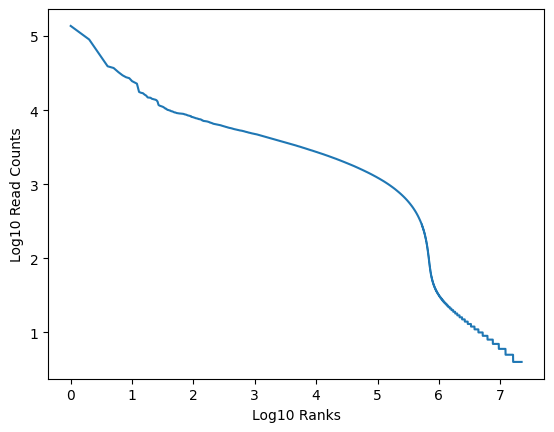

In [12]:
log10_ranks=np.log10(np.arange(1,len(bcs)+1))
log10_cnts=bcs.log10cnt
plt.plot(log10_ranks,log10_cnts)#,label='Rank Plot of Reads')
plt.xlabel('Log10 Ranks')
plt.ylabel('Log10 Read Counts')

In [17]:
bcs[bcs.log10cnt>1]

,xc,log10cnt
0,AAAAAAAAAAAAAA,5.136724
1,AGGCCTTCCCCTAC,4.953571
2,CGGCTCACGGTTCA,4.742851
3,CAGCTCACGGTTCA,4.591943
4,TGGCTCACGGTTCA,4.569058
...,...,...
4395420,TTTTTTTTTTGCTT,1.041393
4395421,TTTTTTTTTTGGTA,1.041393
4395422,TTTTTTTTTTTCGG,1.041393
4395423,TTTTTTTTTTTCTA,1.041393


<AxesSubplot:xlabel='log10cnt', ylabel='Count'>

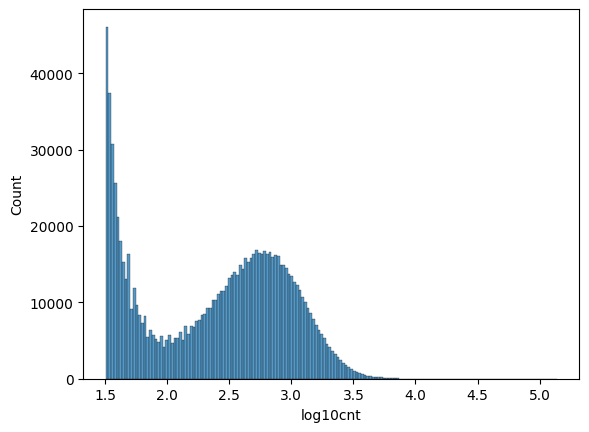

In [20]:
sns.histplot(bcs[bcs.log10cnt>1.5].log10cnt)

# agg whitelist

In [3]:
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

In [ ]:
sample='c55_32'

In [3]:
sample='c55_4'

In [5]:
out_dir='all_fastq'

In [9]:
wl_df=pd.read_csv(f'{out_dir}/{sample}/{sample}_{white_position}_wl.csv.gz',compression='infer',index_col=0)

In [13]:
for white_position in ['targets','anchors']:
    
    for sample in ['c55_4','c55_32']:
    
        agg_bcs=[];total_raw_barcodes=[]

        for i in range(8):
            sub_bc=pd.read_csv(f'{out_dir}/{sample}/split/{sample}.part_00{i+1}_{white_position}.csv.gz')
            batch_cnt=sub_bc.cnt.sum()
            print(batch_cnt)
            total_raw_barcodes.append(batch_cnt)
            agg_bcs.append(sub_bc[sub_bc.cnt>2])

        agg_bcs=pd.concat(agg_bcs)

        agg_bcs=agg_bcs.groupby(agg_bcs.columns[0]).sum()

        agg_bcs=agg_bcs.sort_values(by='cnt',ascending=False)

        agg_bcs['log10cnt']=np.log10(agg_bcs['cnt'])

        x = np.histogram(agg_bcs.iloc[20:100000].log10cnt, 100) # select top 100k bc except first 20
        smooth = gaussian_filter1d(x[0], 3)
        peak_idx,_=find_peaks(-smooth)
        print(peak_idx,x[1][:-1][peak_idx])
        mean_hist=(x[1][1:][peak_idx]+x[1][:-1][peak_idx])/2
        mean_hist=mean_hist[0]

        wl_df=agg_bcs[agg_bcs.log10cnt>=mean_hist].copy()
        
        wl_df.to_csv(f'{out_dir}/{sample}/{sample}_{white_position}_wl.csv.gz',compression='infer')

        wl_reads=wl_df.cnt.sum()

        white_list_size=wl_df.shape[0]

        print(f'{sample} {white_position}\n{np.sum(total_raw_barcodes)/1e6}m raw reads\n{wl_reads/1e6}m reads in whitelist')

        log10_ranks=np.log10(np.arange(1,len(agg_bcs)+1))
        log10_cnts=agg_bcs.log10cnt
        plt.plot(log10_ranks,log10_cnts)#,label='Rank Plot of Reads')
        plt.xlabel('Log10 Ranks')
        plt.ylabel('Log10 Read Counts')
        plt.title(f'{sample} {white_position}\n {white_list_size} white listed')
        plt.plot([0, log10_ranks[-1]], [mean_hist, mean_hist], linewidth=1,label='log10 threshold',c='tab:green')
        log10_wl=np.log10(white_list_size)
        plt.plot([log10_wl, log10_wl], [log10_cnts.min(), log10_cnts.max()], linewidth=1,label='log10 size',c='tab:orange')
        plt.legend(loc="upper right");
        plt.savefig(f'{out_dir}/{sample}/{sample}_{white_position}_rankplot.pdf',bbox_inches='tight');
        plt.close()

        plt.plot(x[1][:-1],x[0], label='Raw Histogram')
        plt.plot(x[1][:-1],smooth, label='Gaussian Smoothed')
        plt.xlabel('Log10 Read Counts')
        plt.ylabel('Bin Height')
        plt.title(f'{sample} {white_position}')
        plt.plot([mean_hist, mean_hist], [0, np.max(x[0])], linewidth=2,label='Whitelist Threshold')
        plt.legend(loc="upper right");
        plt.savefig(f'{out_dir}/{sample}/{sample}_{white_position}_histogram.pdf',bbox_inches='tight');
        plt.close()

23263845
23260932
23268900
23266490
23261408
23269353
23272395
23267574
[42] [3.03702913]
c55_4 targets
186.130897m raw reads
126.377263m reads in whitelist
18619992
18619353
18625608
18622768
18621830
18622967
18618320
18619586
[33] [2.65451423]
c55_32 targets
148.970424m raw reads
98.971891m reads in whitelist
22682491
22681544
22677956
22677694
22687683
22688356
22677488
22680387
[41] [2.89239548]
c55_4 anchors
181.453599m raw reads
133.21487m reads in whitelist
20053271
20050062
20048898
20050567
20052280
20049592
20046345
20052902
[46] [3.00587116]
c55_32 anchors
160.403917m raw reads
116.096584m reads in whitelist


# aggregate quads

In [2]:
sample='c55_32'

In [1]:
sample='c55_4'

In [2]:
out_dir='all_fastq'

In [3]:
i=0

In [6]:
quad=pd.read_csv(f'{out_dir}/{sample}/{sample}_quads.csv.gz',names=['a_bc','a_bumi','t_bc','t_bumi'])

In [12]:
anchors_wl=pd.read_csv(f'{out_dir}/{sample}/{sample}_anchors_wl.csv.gz')

In [13]:
targets_wl=pd.read_csv(f'{out_dir}/{sample}/{sample}_targets_wl.csv.gz')

In [15]:
quad=quad[ (quad.a_bc.isin(anchors_wl.a_bc)) & (quad.t_bc.isin(targets_wl.t_bc)) ].copy()

In [21]:
quad=quad[['a_bc', 'a_bumi', 't_bc']].set_index('a_bc')

In [56]:
quad.to_csv(f'{out_dir}/{sample}/{sample}_quads_filter.csv')

In [80]:
sub_quad.shape[0]

5322

In [90]:
np.log10(np.exp(7.4)*2.8)

3.660937197426283

In [82]:
DUPS=[]
for anch in tqdm(anchors_wl.a_bc[:100]):
    
    sub_quad = quad.loc[anch].copy()
    
    umi_cnt = sort_cnt(sub_quad.a_bumi)
    RATE=sub_quad.shape[0]/umi_cnt.shape[0]
    DUPS.append(RATE)

100%|█████████████████████████████████████████| 100/100 [02:52<00:00,  1.72s/it]


<AxesSubplot: ylabel='Count'>

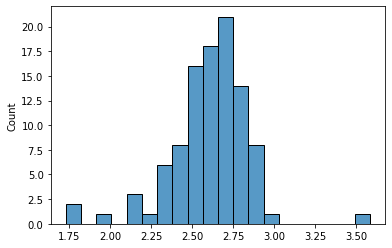

In [87]:
sns.histplot(DUPS,bins=20)

In [25]:
    sub_quad = sub_quad.set_index('a_bumi')
    
    umi_cnt_high = umi_cnt[umi_cnt[1]>1]
    

In [76]:
sub_quad.set_index('a_bumi')

,t_bc
a_bumi,
AGGGAGCA,GTGAAAACGCCAAT
AAGGCCGC,TAGTAGACCTTTCG
GCACAGGC,GGTATCATTTAGAT
CCGGGCAA,TGCAGCTTTAACGG
GCTTCTCC,TAGTAGACCTTTCG
...,...
AAGAACTG,CGGTCATGGCTGCG
CGTCAGGG,TCTGCACTACACTA
CGATGATA,TGCAGCTTTAACGG


In [36]:
umi_cnt

,0,1
474,ATTGGATA,14
1915,TGGGGGCG,13
397,ATCATGCG,12
750,CGAGATTG,12
146,ACCAAAAG,12
...,...,...
1504,GTGTTGTA,1
910,CTCGGCGC,1
1506,GTTACTAA,1
300,AGCCCTGG,1


In [77]:
umi_cnt_high=umi_cnt[umi_cnt[1]>1]

In [78]:
umi_cnt_high

,0,1
474,ATTGGATA,14
1915,TGGGGGCG,13
397,ATCATGCG,12
750,CGAGATTG,12
146,ACCAAAAG,12
...,...,...
1045,GAGCATCG,2
1052,GAGCGTCG,2
1081,GATCGAAG,2
1059,GAGGGAGG,2


In [29]:
umi_cnt=sort_cnt(sub_quad.a_bumi)

In [71]:
umi_cnt_high=umi_cnt[umi_cnt[1]>1]

In [74]:
for umi_cnt_high

,0,1
474,ATTGGATA,14
1915,TGGGGGCG,13
397,ATCATGCG,12
750,CGAGATTG,12
146,ACCAAAAG,12
...,...,...
1045,GAGCATCG,2
1052,GAGCGTCG,2
1081,GATCGAAG,2
1059,GAGGGAGG,2


In [61]:
target_cnt=sub_quad[sub_quad.a_bumi=='TGGGGGCG'].t_bc.value_counts()

In [70]:
target_cnt

t_bc
TGCAGCTTTAACGG    7
GTGAAAACGCCAAT    6
Name: count, dtype: int64

In [68]:
target_cnt[0]

7

In [ ]:
target_cnt[0]

In [66]:
target_cnt

t_bc
TGCAGCTTTAACGG    7
GTGAAAACGCCAAT    6
Name: count, dtype: int64

In [54]:
sub_quad[sub_quad.a_bumi=='TAGGGGTA'].t_bc.value_counts()

t_bc
TAGAAAAACGAATT    10
Name: count, dtype: int64

# python csv writer

In [ ]:
import csv


with open('mycsvfile.csv','w') as f:
    w = csv.writer(f)
    w.writerows([('bc','cnt')])
    w.writerows(raw_anchors.items())

In [102]:
import csv


with open('mycsvfile2.csv','w') as f:
    w = csv.DictWriter(f, raw_anchors.keys())
    w.writeheader()
    w.writerow(raw_anchors)

In [ ]:
bcs=pd.DataFrame(pd.Series(raw_anchors))n

# extract_bc_umi (moved to script)

In [26]:
UP_seq='TCTTCAGCGTTCCCGAGA'

In [ ]:
os.listdir(f'{fastq_dir}/{sample}/split/')

In [ ]:
fqs=sorted([f'{outdir}/split/'+f for f in os.listdir(f'{fastq_dir}/{sample}/split/') if f.endswith('gz')])

In [ ]:
for i in range(int(cores)): align_trns(i)

args=[]

for i in range(int(cores)): args.append((f'part_00{i+1}',f'{outdir}/split'))

In [ ]:
pool = Pool(int(cores))
results = pool.starmap(utils.decon_5p10XTCR, args)
pool.close()

In [128]:
#R1_fastq = f'{fastq_dir}/{sample}/split/{sample}_R1_001.part_001.fastq.gz'
R2_fastq = f'{fastq_dir}/{sample}/split/{sample}_R2_001.part_001.fastq.gz'

In [130]:
R2_fastq

'/Users/mborji/reconstruct/230803/fastq//c55_32_rec_S1/split/c55_32_rec_S1.part_001.csv'

In [ ]:
all_bc_umi

In [351]:
samples

array(['c55_32_rec_S1', 'c55_34_rec_S4', 'c55_4_rec_S1', 'c55_5_rec_S2'],
      dtype='<U13')

# aggregate csvs (done above)

In [352]:
samples

array(['c55_32_rec_S1', 'c55_34_rec_S4', 'c55_4_rec_S1', 'c55_5_rec_S2'],
      dtype='<U13')

In [353]:
samples=['c55_32_rec_S1', 'c55_34_rec_S4', 'c55_4_rec_S1', 'c55_5_rec_S2']

In [354]:
for sample in samples:
    
    files = os.listdir(f'{fastq_dir}/{sample}/split/')

    csv_files = [f for f in files if '.csv.gz' in f]

    all_csvs=[]
    for csv in csv_files:
        all_csvs.append(pd.read_csv(f'{fastq_dir}/{sample}/split/{csv}',names = ['a_bc','a_bumi','t_bc','t_bumi']))

    all_bc_umi = pd.concat(all_csvs)
    
    print(sample,all_bc_umi.shape)
    
    all_bc_umi_name = f'{fastq_dir}/{sample}/{sample}_all_bc_umi.csv'
    all_bc_umi.to_csv(all_bc_umi_name,index=None)
    subprocess.call([ 'pigz', '-f', all_bc_umi_name ])

    a_bc_cnt=sort_cnt(all_bc_umi.a_bc)
    a_bc_cnt=a_bc_cnt[a_bc_cnt[1]>3]
    a_bc_cnt.columns=['bc','read_cnt']
    a_bc_cnt_name = f'{fastq_dir}/{sample}/{sample}_a_bc_cnt.csv'
    a_bc_cnt.to_csv(a_bc_cnt_name, index=None)
    subprocess.call([ 'pigz', '-f', a_bc_cnt_name ])

    t_bc_cnt=sort_cnt(all_bc_umi.t_bc)
    t_bc_cnt=t_bc_cnt[t_bc_cnt[1]>3]
    t_bc_cnt.columns=['bc','read_cnt']
    t_bc_cnt_name = f'{fastq_dir}/{sample}/{sample}_t_bc_cnt.csv'
    t_bc_cnt.to_csv(t_bc_cnt_name,index=None)
    subprocess.call([ 'pigz', '-f', t_bc_cnt_name ])

c55_32_rec_S1 (7710908, 4)
c55_34_rec_S4 (7167354, 4)
c55_4_rec_S1 (10773322, 4)
c55_5_rec_S2 (10649318, 4)


In [356]:
'c55_32_rec_S1',7710908/2302847*10

('c55_32_rec_S1', 33.484239291624675)

In [355]:
'c55_34_rec_S4',7167354/2268534*10

('c55_34_rec_S4', 31.594650994871575)

In [359]:
'c55_4_rec_S1',10773322/3009891*10

('c55_4_rec_S1', 35.79306360263544)

In [360]:
'c55_5_rec_S2',10649318/2537970*10

('c55_5_rec_S2', 41.95998376655359)

In [296]:
all_bc_umi2=pd.read_csv(f'{fastq_dir}/{sample}/all_bc_umi.csv',dtype='str',engine='c')

all_bc_umi2

# make rank/histogram plots (done above)

In [2]:
fastq_dir='/Users/mborji/reconstruct/230803/fastq/'
files=sorted(os.listdir(fastq_dir))
samples=np.unique([f.split('_R')[0] for f in files if 'fastq.gz' in f])
samples

array(['c55_32_rec_S1', 'c55_34_rec_S4', 'c55_4_rec_S1', 'c55_5_rec_S2'],
      dtype='<U13')

32
34
4
5


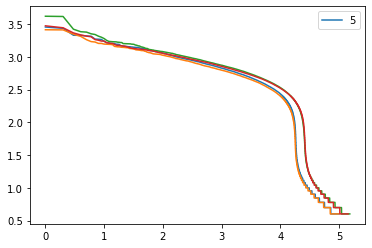

In [23]:
for sample in samples:

    a_bc_cnt_name = f'{fastq_dir}/{sample}/{sample}_a_bc_cnt.csv.gz'
    a_bc_cnt=pd.read_csv(a_bc_cnt_name, index_col=0)
    plt.plot(np.log10(np.arange(1,len(a_bc_cnt)+1)),np.log10(a_bc_cnt['read_cnt']));
    print(sample.split('_')[1])
    plt.legend(sample.split('_')[1])
    

In [205]:
from scipy.signal import argrelextrema

print(argrelextrema(smooth, np.greater))
print(argrelextrema(smooth, np.less))


(array([110]),)
(array([56]),)


In [184]:
hist=pd.DataFrame([a[0],a[1]]).T

In [46]:
from scipy.interpolate import CubicSpline

In [60]:
from scipy.interpolate import UnivariateSpline

In [66]:
from scipy.interpolate import InterpolatedUnivariateSpline

In [76]:
cs = CubicSpline(a[1][:-1], a[0])

In [78]:
cs = UnivariateSpline(a[1][:-1], a[0])

In [80]:
cs = InterpolatedUnivariateSpline(a[1][:-1], a[0])

In [68]:
xs=a[1][:-1]
ys=a[0]

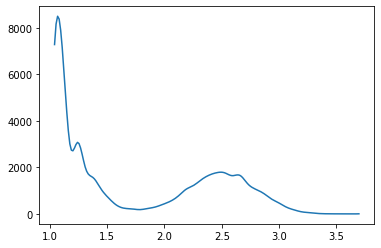

In [77]:
x_range = np.arange(xs[0], xs[-1], (xs[-1]-xs[0])/200)
plt.plot(x_range, cs(x_range), label='Cubic Spline')

32
(35611, 1) (40351, 1)
34
(34622, 1) (39825, 1)
4
(20651, 1) (26205, 1)
5
(19954, 1) (27766, 1)


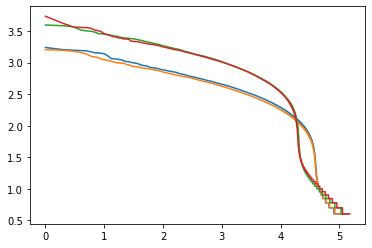

In [ ]:
cutoff_rank_start=0
for sample in samples:

    t_bc_cnt_name = f'{fastq_dir}/{sample}/{sample}_t_bc_cnt.csv.gz'
    t_bc_cnt=pd.read_csv(t_bc_cnt_name, index_col=0)
    df_sub=t_bc_cnt.iloc[cutoff_rank_start:].copy()
    plt.plot(np.log10(np.arange(1,len(df_sub)+1)),np.log10(df_sub['read_cnt']));
    print(sample.split('_')[1])
    #plt.legend(sample.split('_')[1])
    print(t_bc_cnt[t_bc_cnt.read_cnt>50].shape,t_bc_cnt[t_bc_cnt.read_cnt>18].shape)
    

In [295]:
10**1.3

19.952623149688797

In [ ]:
plt.ylabel('log10 UMI counts')
plt.xlabel('log10 cell rank')
plt.title('library knee plot')
plt.savefig(f'{outdir}/{sample}_knee.pdf',bbox_inches='tight');

In [211]:
f'{fastq_dir}/{sample}/all_bc_umi.csv'

'/Users/mborji/reconstruct/230803/fastq//c55_32_rec_S1/all_bc_umi.csv'

# UP stats (shallow data)

In [103]:
bcs=pd.read_csv(f'{fastq_dir}/{sample}_white.csv.gz',names=['a_bc','a_bumi','t_bc','t_bumi'])

In [183]:
bcs=pd.read_csv(f'{fastq_dir}/{sample}/split/{sample}.part_001.csv.gz',names=['a_bc','a_bumi','t_bc','t_bumi'])

In [191]:
bcs2=pd.read_csv(f'{fastq_dir}/{sample}/split/{sample}.part_002.csv.gz',names=['a_bc','a_bumi','t_bc','t_bumi'])

In [184]:
bcs2=pd.read_csv(f'{fastq_dir}/{sample}_white.csv.gz',names=['a_bc','a_bumi','t_bc','t_bumi'])

In [198]:
bcs2[bcs2.a_bc.isin(set(bcs2.a_bc) & set(bcs.a_bc))].a_bc.value_counts()

TAGCTTCCTCGCCG    188
ATACCATGTAGATA    166
GATAAATCCACACT    165
AAACCACGTTTCTT    156
ACTTGCTAGATCAG    153
                 ... 
TCGCCGCTTCGGGA      1
CATGGTATTCATTA      1
GGATGGATTGTGCC      1
GTGAGAATCAACAG      1
ATTCTTGGAAACGA      1
Name: a_bc, Length: 38803, dtype: int64

In [ ]:
for sample in samples:
    
    for read in ['R1','R2']:
        
        fastq=f'{fastq_dir}/{sample}_{read}_001.fastq.gz'
    
        i=0;seqs=[];max_dist=3;starts=[];ends=[];eds=[]
        
        fh= pysam.FastxFile(fastq) as fh:
            for entry in tqdm(fh):
                i+=1
                #seqs.append(len(entry.sequence))
                #name=int(entry.name.split('/')[-2])

                ed=edlib.align(slseq,entry.sequence,'HW','locations',max_dist,ad_seq)

                if ed['editDistance']>-1 and ed['editDistance']<=max_dist:
                    #print(ed,entry.sequence)
                    #if ed['editDistance']==1 and ed['locations'][0][1]==24:print(ed,entry.sequence)
                    eds.append([ ed['editDistance'], ed['locations'][0][0], ed['locations'][0][1] ])
                if i>100000: break
        
        eds=pd.DataFrame(eds)
        eds.to_csv(f'read_stats_{sample}_{read}.csv.gz',compression='infer',index=None)

100000it [00:01, 82323.56it/s]
100000it [00:01, 76863.83it/s]
100000it [00:01, 81332.03it/s]
100000it [00:01, 76497.45it/s]
100000it [00:01, 78020.24it/s]
100000it [00:01, 73300.08it/s]
100000it [00:01, 83327.90it/s]
100000it [00:01, 83355.14it/s]


In [181]:
for sample in samples:
    
    for read in ['R1','R2']:
        
        stats=pd.read_csv(f'read_stats_{sample}_{read}.csv.gz')
        
        print(f'read_stats_{sample}_{read}')
        edit_cnts=stats['0'].value_counts()/1e5*100
        edit_cnts.index='% reads UP_dist='+edit_cnts.index.astype('str')
        print(edit_cnts.to_string())
        print()
    print(27*'-')
        

read_stats_c55_32_rec_S1_R1
% reads UP_dist=0    56.035
% reads UP_dist=1     7.926
% reads UP_dist=2     1.284
% reads UP_dist=3     1.184

read_stats_c55_32_rec_S1_R2
% reads UP_dist=0    46.581
% reads UP_dist=1    11.366
% reads UP_dist=2     2.358
% reads UP_dist=3     1.084

---------------------------
read_stats_c55_34_rec_S4_R1
% reads UP_dist=0    51.744
% reads UP_dist=1     7.843
% reads UP_dist=2     1.080
% reads UP_dist=3     0.897

read_stats_c55_34_rec_S4_R2
% reads UP_dist=0    48.869
% reads UP_dist=1    11.928
% reads UP_dist=2     2.319
% reads UP_dist=3     1.104

---------------------------
read_stats_c55_4_rec_S1_R1
% reads UP_dist=0    55.118
% reads UP_dist=1     8.389
% reads UP_dist=2     1.063
% reads UP_dist=3     0.845

read_stats_c55_4_rec_S1_R2
% reads UP_dist=0    51.340
% reads UP_dist=1    11.691
% reads UP_dist=2     2.250
% reads UP_dist=3     1.057

---------------------------
read_stats_c55_5_rec_S2_R1
% reads UP_dist=0    60.254
% reads UP_dist=1

In [121]:
eds[eds[0]==1][2].value_counts().head()

25    5794
24    1414
26     247
23      92
16      74
Name: 2, dtype: int64

In [71]:
ends['category']=ends[0].astype('str')+'_'+ends[1].astype('str')

In [73]:
sort_cnt(ends.category).to_csv(f'18milion_perfectUP_{sample}_R2.csv')

In [79]:
cats=pd.read_csv(f'18milion_perfectUP_{sample}_R2.csv',index_col=0)

In [81]:
cats.to_csv(f'18milion_perfectUP_{sample}_R2.csv',index=None)

In [89]:
8117774/18e7

0.04509874444444444

In [88]:
cats['1']

31    8117774
30     135389
29      22322
32      18117
9        9080
27       7433
28       6424
10       4150
17       3311
26       2851
0        2116
7        2011
12       1950
19       1742
18       1716
8        1479
16       1472
15       1278
13       1269
14       1216
22       1209
20       1121
11       1047
1        1012
21        724
23        604
3         553
6         538
2         493
24        394
5         335
4         330
25        323
Name: 1, dtype: int64

In [58]:
starts=np.array(starts)
ends=np.array(ends)

<AxesSubplot:ylabel='Count'>

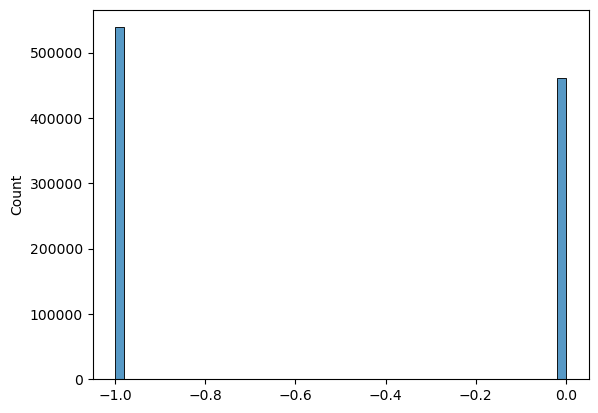

In [ ]:
sns.histplot(eds)

# test new data

In [61]:
import importlib
importlib.reload(run_bc_umi_extract)

TCTTCAGCGTTCCCGAGA
1000000


<module 'run_bc_umi_extract' from '/Users/mborji/reconstruct/run_bc_umi_extract.py'>

In [25]:
fastq_dir='/Users/mborji/reconstruct/all_fastq/'

In [62]:
files=sorted(os.listdir(fastq_dir))
samples=np.unique([f.split('_R')[0] for f in files if 'fastq.gz' in f])

In [64]:
sub_samples=['c55_32_S2', 'c55_32_rec_S1', 'c55_4_S1', 'c55_4_rec_S1']

In [71]:
sub_samples

['c55_32_S2', 'c55_32_rec_S1', 'c55_4_S1', 'c55_4_rec_S1']

In [66]:
samples
sample=samples[0]
print(sample)

c55_32_S2


In [67]:
for sample in sub_samples:
    R1=f'{fastq_dir}{sample}_R1_001.fastq.gz'
    R2=f'{fastq_dir}{sample}_R2_001.fastq.gz'
    run_bc_umi_extract.extract_bc_umi(R1,R2)

1000000it [00:16, 61180.15it/s]
1000000it [00:16, 61523.68it/s]
1000000it [00:16, 60682.70it/s]
1000000it [00:16, 60412.93it/s]


In [68]:
for sample in sub_samples:
    csv=pd.read_csv(f'{fastq_dir}{sample}.csv.gz',names=['a_bc','a_bumi','t_bc','t_bumi'])
    print(sample)
    #print(sort_cnt(csv.a_bc).head(50)[0].tolist())
    print()

c55_32_S2
['AAACCACGTTTCTT', 'CAATGTCCGAACAT', 'TAGCTTCCTCGCCG', 'TCAAGTTACGATGA', 'TTCGTAGAAAGTCC', 'ATACCATGTAGATA', 'TCAAGCTGCATTGA', 'GGTGCACGGTCCTT', 'CTAACGACCACATA', 'TATACTGTCGCGCA', 'CTGTTATTCAGCCC', 'TTCTTAGTCAGCCA', 'CTACTTAATCTCCA', 'AAATCCTTCATGCC', 'TATTTAATGAGCCC', 'ACTAGCACGGATCT', 'ACTTGCTAGATCAG', 'TTTATTTTCCACTT', 'TTGGACTTTGCTTT', 'ATTACTCGTTGCCT', 'CTTCGCATGGTATG', 'CTCTTCTAGCTCTA', 'CTGATTGAACGACC', 'TTAAATCCCATTGG', 'TGAAGGTTCGACAG', 'TGCAGCAAATTGCA', 'ACTCCCTTACGCAC', 'TAGCCCGGAGCCGG', 'ACACCAGTGTACGT', 'TTAGAATGTCTAGC', 'CTTCTACTGCCAAT', 'CCACTAAAACGCAC', 'TGAGGTTACCTGTA', 'GTTCTTTAGTCGGC', 'TTTTATAATTACCT', 'CTCACCACGGTTAA', 'GGATAAGCATCGAC', 'CCAGATTTTTCTCC', 'CTTTTAATCGACTG', 'TTCTTGCAGCCATT', 'TAATACCGATGTAG', 'CGACATGTAGGCCT', 'CACAGTTATTTTCC', 'CATGCCCATTCCTC', 'TAATGCCGAGCTAT', 'GAAAGAGGCACAGT', 'ACGGATCGGGACTA', 'ACTAGAGCTGAGGG', 'ATCTACGACTTAAG', 'TCTTTAGAGGCGAC']

c55_32_rec_S1
['AAACCACGTTTCTT', 'CAATGTCCGAACAT', 'TAGCTTCCTCGCCG', 'ATACCATGTAGATA', '

In [ ]:
for sample in sub_samples:
    csv=pd.read_csv(f'{fastq_dir}{sample}.csv.gz',names=['a_bc','a_bumi','t_bc','t_bumi'])
    print(sample,csv.shape)
    #print(sort_cnt(csv.a_bc).head(50)[0].tolist())
    print()
    

In [ ]:
sample=samples[0]

parts=np.unique([f.split('.')[-3] for f in os.listdir(f'{fastq_dir}/{sample}/split/')])

R1s=[f for f in os.listdir(f'{fastq_dir}/{sample}/split/') if '_R1_001.part' in f]
R2s=[f.replace('_R1_','_R2_') for f in R1s]

args=[]

for i in range(len(R1s)): 
    args.append((f'{fastq_dir}/{sample}/split/{R1s[i]}',f'{fastq_dir}/{sample}/split/{R2s[i]}'))

# chenlei out

In [34]:
d=pd.read_csv('/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct/chenlei_out/c55_32/c55_32_aligment_statistics.csv')

In [38]:
d=pd.read_csv('/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct/chenlei_out/c55_32/c55_32_blind_raw_reads_filtered.csv.gz')

In [2]:
d2=pd.read_csv('/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct/chenlei_out/c55_32/c55_32_raw_matched_reads.csv.gz')

In [31]:
d2=pd.read_csv('/n/data2/dfci/medonc/cwu/meb521/slideseq/reconstruct/chenlei_out/c55_4/c55_4_raw_matched_reads.csv.gz')

In [36]:
T_rep=4*'T'

In [44]:
T_rep='TTGTT'

In [45]:
all_umi=[]
for umi in d2.P5_bumi:
    if T_rep in umi:
        all_umi.append(umi)

In [46]:
len(all_umi)

13029

In [47]:
sort_cnt(all_umi).head(50)

,0,1
107,GCTTGTTC,136
59,CCTTGTTC,123
210,TTGTTGGG,120
80,CTTGTTCG,119
84,CTTGTTGG,118
115,GGTTGTTC,117
108,GCTTGTTG,117
12,ACTTGTTC,115
79,CTTGTTCC,114
139,GTTTGTTC,113


In [17]:
sub=d2[d2.P5_bc=='TTAACCGATGTCAG']

In [19]:
sub.P5_bumi.value_counts()

TTTTTTTT    11
CGGATGGG     7
GTTTTTTT     6
GGAGTCAC     4
GGGGCGAA     4
            ..
GGTCTGAC     1
TTGAACTA     1
TTCTGTGA     1
TGGCGCAG     1
TTGATCGG     1
Name: P5_bumi, Length: 6887, dtype: int64

In [ ]:
sub[sub.P5_bumi=='CGGATGGG']

,P5_bc,V9_bc,P5_bumi,V9_bumi,reads
1875361,TTAACCGATGTCAG,TAAATAGTAATACG,CGGATGGG,AGAAACCC,1
1875620,TTAACCGATGTCAG,TAAAAATTAAAACT,CGGATGGG,AGAAACCC,1
1876798,TTAACCGATGTCAG,TATATAGTAATACG,CGGATGGG,AGAATCCC,2
1877930,TTAACCGATGTCAG,TTTAAATTATTACG,CGGATGGG,AGAATCCC,1
1878927,TTAACCGATGTCAG,TATTTATTATTAAC,CGGATGGG,AGAATCCC,1
1879396,TTAACCGATGTCAG,TATATAGTAATACG,CGGATGGG,AGAATCCA,1
1880077,TTAACCGATGTCAG,TATATAGTAATACG,CGGATGGG,AGAATACC,1


In [24]:
d2[d2.V9_bc=='TAAAAATTAAAACT'].shape

(44, 5)

In [26]:
d2[d2.P5_bc=='GGGTAATTCATGCT']

,P5_bc,V9_bc,P5_bumi,V9_bumi,reads
765924,GGGTAATTCATGCT,AGAGTTTATCTCGT,GACAACCC,GAGTACAC,8
765925,GGGTAATTCATGCT,ACTTTTCGTTAATC,TACTGGAA,CAACGCTA,4
765926,GGGTAATTCATGCT,AGAGTTTATCTCGT,ACGAACCA,TCATATTC,5
765927,GGGTAATTCATGCT,AGGGGTGGTGGCCT,GTGTACAC,CGTTACCC,3
765928,GGGTAATTCATGCT,AGAGTTTATCTCGT,CACGCTGG,CAGCGACA,2
...,...,...,...,...,...
766348,GGGTAATTCATGCT,TTCCCTCCTTCCAG,GTTAAGGG,GCGTCACC,1
766349,GGGTAATTCATGCT,AGATGGTAGGGTAT,CTGGTCTC,ACACCCTG,2
766350,GGGTAATTCATGCT,AGCGTGGCTTCCGG,CTAATTAG,AACAAACA,1
766351,GGGTAATTCATGCT,TAATACACAGGATA,TCCACCAA,ACCCAGGA,1


In [11]:
P5_cnt=sort_cnt(d2.P5_bc)

In [61]:
V9_bc=sort_cnt(d.V9_bc)

In [12]:
P5_cnt['log10']=np.log(P5_cnt[1])

In [5]:
V9_bc['log10']=np.log(V9_bc[1])

NameError: name 'V9_bc' is not defined

In [59]:
P5_cnt.to_csv('chu_P5_cnt.csv.gz',index=None,compression='infer')

In [63]:
V9_bc.to_csv('chu_V9_cnt.csv.gz',index=None,compression='infer')

<AxesSubplot:xlabel='log10', ylabel='Count'>

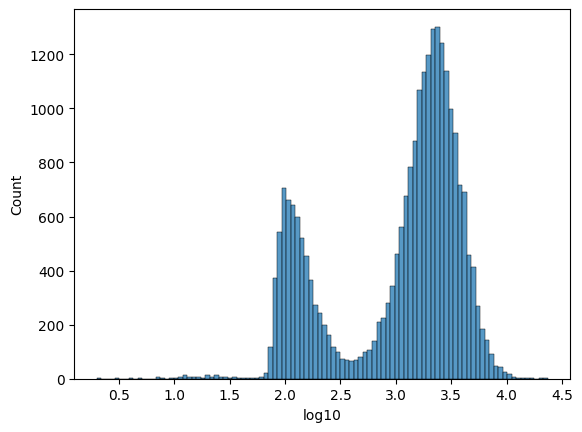

In [46]:
sns.histplot(P5_cnt['log10'],bins=100)

In [8]:
P5_cnt

,0,1,log10
50871,TAGCTTCCTTGCCG,10879,9.294590
64786,TTTGTAGAAAGTCC,7927,8.978030
29222,CTCTTCTAGCTCTA,7006,8.854522
20283,CCATATTTTTCTCC,6689,8.808220
42657,GGTGCACGGTCCTT,6665,8.804625
...,...,...,...
56430,TCTTTTATTTATCT,1,0.000000
56432,TCTTTTATTTTTCT,1,0.000000
40515,GGGGCAGCTGGGTT,1,0.000000
40514,GGGGCAGCCCGGCG,1,0.000000


<AxesSubplot:xlabel='log10', ylabel='Count'>

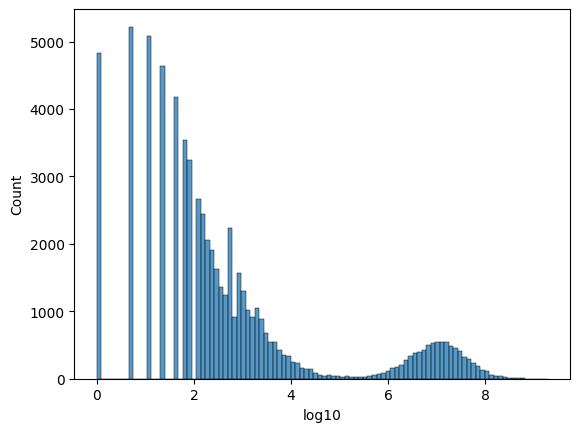

In [7]:
sns.histplot(P5_cnt['log10'],bins=100)

<AxesSubplot:xlabel='log10', ylabel='Count'>

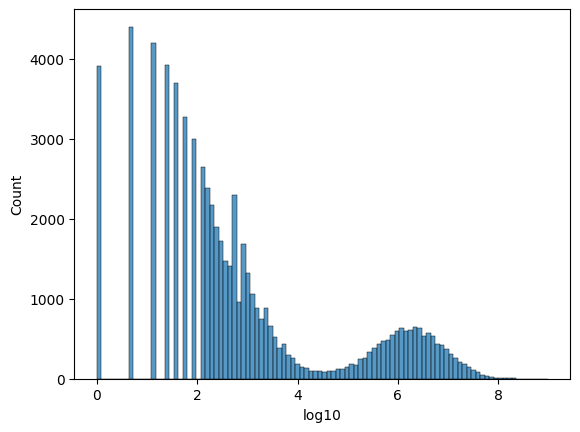

In [13]:
sns.histplot(P5_cnt['log10'],bins=100)

In [29]:
P5_cnt[P5_cnt.log10>4.5]

,0,1,log10
58534,TTAACCGATGTCAG,8024,8.990192
30327,CTTTGAGCACTCTC,4536,8.419801
27673,CTATCATTATCGAT,4386,8.386173
52224,TCCAGACGGGAGAT,4272,8.359837
42615,GGTTATTTCTTATT,3980,8.289037
...,...,...,...
16342,CAAAGCCATAAGGA,91,4.510860
7857,AATGCGGAACACTG,91,4.510860
3132,AAATCATAGGAGCT,91,4.510860
41988,GGTCCGCCGTGTCC,91,4.510860


In [31]:
p1

NameError: name 'p1' is not defined

<AxesSubplot:xlabel='log10', ylabel='Count'>

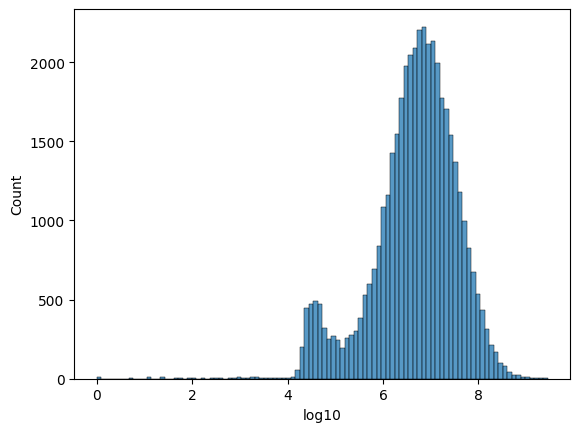

In [64]:
sns.histplot(V9_bc['log10'],bins=100)

<AxesSubplot:xlabel='nlog10', ylabel='Count'>

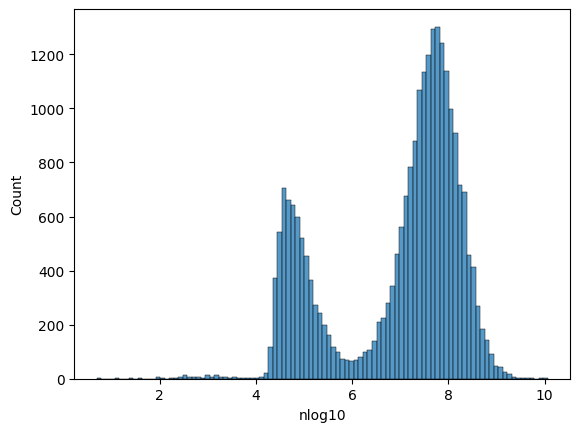

In [57]:
sns.histplot(P5_cnt['nlog10'],bins=100)

In [48]:
P5_cnt

,0,1,log10
116,AAACCACGTTTCTT,23612,4.373133
19435,TAGCTTCCTCGCCG,20930,4.320769
23852,TTCGTAGAAAGTCC,16705,4.222846
6546,CAATGTCCGAACAT,15519,4.190864
11368,CTCTTCTAGCTCTA,15033,4.177046
...,...,...,...
3920,AGGATTGCAGGCTG,5,0.698970
8448,CCCTGCAAGACCAT,4,0.602060
21235,TCTATTTCTTCCAT,4,0.602060
19797,TATGAAGCAGCCTC,3,0.477121


In [55]:
np.log10(np.exp(5.4))

2.34519020227756

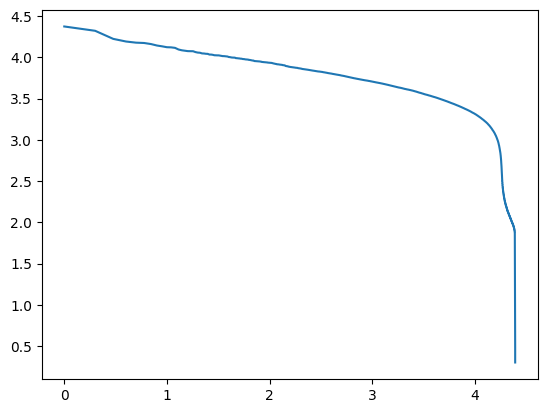

In [42]:
plt.plot(np.log10(np.arange(1,len(P5_cnt)+1)),np.log10(P5_cnt[1]));

In [37]:
d

,alignment_status,counts
0,total_reads,234490270
1,UP_not_matched,155884792
2,Read_too_short,850
3,matched_reads,60712154
